In [ ]:
import requests
from bs4 import BeautifulSoup
import lxml
import csv
import pandas as pd
import numpy as np
import logging
import collections
import csv
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib


In [ ]:
logging.basicConfig(level = logging.DEBUG)
logger = logging.getLogger('lr')

ParseResult = collections.namedtuple(
'ParseResult',
(
'url',
'book_name',
'author_name',
'price',
'star',
'quantity',
'page_volume',
'genre',
'author_info'
),
)

HEADERS = (
'Ссылка',
'Название книги',
'Имя автора',
'Цена книги',
'Оценка',
'Кол-во оценок',
'Кол-во страниц',
'Жанр',
'Кол-во книг у автора',
)

class LitRes:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
        'Accept-Language': 'ru',
        }
        self.result = []

    def load_page(self, page):
        if page > 1:
            url = 'https://www.litres.ru/knigi-sovremennaya-proza/' + 'page-' + str(page)
        else:
            url = 'https://www.litres.ru/knigi-sovremennaya-proza/'
        res = self.session.get(url = url)
        res.raise_for_status()
        return res.text

    def parse_page(self, text):
        soup = BeautifulSoup(text, 'lxml')
        container = soup.select('div.art-item.mgrid')
        for block in container[:1]:
            self.parse_block(block = block)

    def parse_block(self, block):
        #logger.info(block)
        #logger.info('=' * 100)
        url_base = 'https://www.litres.ru'
        url_block = block.select_one('a.img-a')
        if not url_block:
            logger.error('no url_block')
            return
        url = url_base + url_block.get('href')
        #print(url)
        if not url:
            logger.error('no url')
            return
        book = block.select_one('div.art__name').select_one('a.art__name__href')
        name_book = book.select_one('span')
        if not name_book:
            logger.error('no book name')
            return
        author = block.select_one('div.art__author')
        author_book = author.select_one('a')
        if not author_book:
            logger.error('no book author')
            return
        url_author = url_base + author_book.get('href')
        name_book = name_book.text
        name_book = name_book.replace('/', '').strip()
        author_book = author_book.text
        author_book = author_book.replace('/', '').strip()
        text = self.load_page_info(url = url)
        price = self.parse_page_info(text = text, what = 'price')
        star = self.parse_page_info(text = text, what = 'rating')[0]
        quantity = self.parse_page_info(text = text, what = 'rating')[1]
        page_volume = self.parse_page_info(text = text, what = 'page_volume')
        genre = self.parse_page_info(text = text, what = 'genre')
        text = self.load_page_info(url = url_author)
        author_info = self.parse_page_info(text = text, what = 'author_info')

        self.result.append(ParseResult(
        url = url,
        book_name = name_book,
        author_name = author_book,
        price = price,
        star = star,
        quantity = quantity,
        page_volume = page_volume,
        genre = genre,
        author_info = author_info,
        ))

        #logger.debug('%s, %s, %s', url, name_book, author_book)
        #logger.debug('-' * 100)

    def load_page_info(self, url):
        url = url
        res = self.session.get(url = url)
        res.raise_for_status()
        return res.text

    def parse_page_info(self, text, what):
        soup = BeautifulSoup(text, 'lxml')
        if what == 'price':
            #container = soup.select('div.biblio_book_buy.clickteg')
            container = soup.select('button.coolbtn.btn-green.a_buyany')
        elif what == 'rating':
            container = soup.select('div.rating-text-wrapper')
        elif what == 'page_volume':
            container = soup.select('li.volume')
        elif what == 'genre':
            container = soup.select('a.biblio_info__link')
        elif what == 'author_info':
            container = soup.select('span.count')
        for block in container:
            x = self.parse_block_info(block = block, what = what)
            return x

    def parse_block_info(self, block, what):
        if what == 'rating':
            star_block = block.select_one('div.rating-number.bottomline-rating')
            if not star_block:
                logger.error('no star block')
                return
            quantity_block = block.select_one('div.votes-count.bottomline-rating-count')
            if not quantity_block:
                logger.error('no quantity block')
                return
            star_block = star_block.text.replace('/', '').strip()
            quantity_block = quantity_block.text.replace('/', '').strip()
            return [star_block, quantity_block]
        elif what == 'price':
            price_block = block.select_one('span.new-price')
            if not price_block:
            price_block = block.select_one('span.simple-price')
                if not price_block:
                logger.error('no price block')
                    return
            price_block = price_block.text.replace('/', '').strip()
            return price_block
        elif what == 'page_volume':
            page_volume = block.text.replace('/', '').strip()
            return page_volume
        elif what == 'genre':
            genre = block.text.replace('/', '').strip()
            return genre
        elif what == 'author_info':
            author_info = block.text.replace('/', '').strip()
            return author_info

    def run(self):
        for i in range(1):
            text = self.load_page(i)
            self.parse_page(text = text)
        logger.info(f'Получили {len(self.result)} элементов')
        self.save_result()

    def save_result(self):
        path = '/Users/a181464/Desktop/финаха/МО/ДТЗ LitRes/df.csv'
        with open(path, 'w') as f:
            writer = csv.writer(f, quoting = csv.QUOTE_MINIMAL)
            writer.writerow(HEADERS)
            for item in self.result:
            writer.writerow(item)


if __name__ == '__main__':
    parser = LitRes()
    parser.run()

In [ ]:
df = pd.read_csv('/Users/a181464/Desktop/финаха/МО/ДТЗ LitRes/df.csv')
df

,Ссылка,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,https://www.litres.ru/fredrik-bakman/trevozhny...,Тревожные люди,Фредрик Бакман,349 ₽,"4,6",885,Объем: 300 стр. 1 иллюстрация,современная зарубежная литература,22,Текст
1,https://www.litres.ru/evgeniy-vodolazkin/oprav...,Оправдание Острова,Евгений Водолазкин,499 ₽,"4,3",71,Объем: 290 стр.,современная русская литература,38,Текст
2,https://www.litres.ru/fredrik-bakman/vtoraya-z...,Вторая жизнь Уве,Фредрик Бакман,299 ₽,"4,8",5082,Объем: 330 стр. 41 иллюстрация,современная зарубежная литература,22,Текст
3,https://www.litres.ru/boris-akunin/mir-i-voyna/,Мир и война,Борис Акунин,419 ₽,"4,4",1844,Объем: 250 стр. 59 иллюстраций,историческая литература,239,Текст
4,https://www.litres.ru/evgeniy-vodolazkin/lavr/,Лавр,Евгений Водолазкин,399 ₽,"4,5",3188,Объем: 390 стр. 43 иллюстрации,историческая литература,38,Текст
...,...,...,...,...,...,...,...,...,...,...
515,https://www.litres.ru/viktor-remizov/vechnaya-...,Вечная мерзлота,Виктор Ремизов,299 ₽,"4,5",19,Объем: 1160 стр.,историческая литература,7,Текст
516,https://www.litres.ru/svetlana-sachkova-241428...,Люди и птицы,Светлана Сачкова,289 ₽,"4,4",30,Объем: 450 стр.,современная русская литература,2,Текст
517,https://www.litres.ru/edvard-radzinskiy/russki...,Русские цари,Эдвард Радзинский,579 ₽,"4,0",7,Объем: 1120 стр.,биографии и мемуары,97,Текст
518,https://www.litres.ru/aleksandr-mihaylovskiy-4...,Пусть ярость благородная,Александр Михайловский,164 ₽,"4,3",199,Объем: 380 стр.,исторические приключения,104,Текст


In [ ]:
df['Цена книги'][0]

'349\xa0₽'

In [ ]:

a = df['Цена книги'][0]
a = int(re.findall('\d*', a)[0])
a

349

In [ ]:
for i in range(len(df['Цена книги'])):
    df['Цена книги'][i] = int(re.findall('\d*', df['Цена книги'][i])[0])
    df['Кол-во оценок'][i] =int(df['Кол-во оценок'][i].replace(' ', ''))
    df['Оценка'][i] = float(df['Оценка'][i].replace(',', '.'))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing t

In [ ]:
df['Кол-во страниц'][0]

'Объем: 300 стр. 1 иллюстрация'

In [ ]:
def repl_text(a):
    a = a.replace('Объем: ', '')
    a = int(re.findall('\d*', a)[0])
    return a

In [ ]:
df['Кол-во страниц'][50]

'Длительность: 6 ч. 38 мин. 06 сек.'

In [ ]:
def repl_audio(a):
    a = a.replace('Длительность: ', '').replace(' ч.', '').replace(' мин.', '').replace(' сек.', '')
    a = re.findall('\d*', a)
    x = (int(a[0]) * 3600 + int(a[2]) * 60 + int(a[4])) / 150
    return x

In [ ]:
df['Тип'][275] = 'Текст'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for i in range(len(df)):
    if df['Тип'][i] == 'Текст':
        df['Кол-во страниц'][i] = repl_text(df['Кол-во страниц'][i])
    else:
        df['Кол-во страниц'][i] = repl_audio(df['Кол-во страниц'][i])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df

,Ссылка,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,https://www.litres.ru/fredrik-bakman/trevozhny...,Тревожные люди,Фредрик Бакман,349,4.6,885,300,современная зарубежная литература,22,Текст
1,https://www.litres.ru/evgeniy-vodolazkin/oprav...,Оправдание Острова,Евгений Водолазкин,499,4.3,71,290,современная русская литература,38,Текст
2,https://www.litres.ru/fredrik-bakman/vtoraya-z...,Вторая жизнь Уве,Фредрик Бакман,299,4.8,5082,330,современная зарубежная литература,22,Текст
3,https://www.litres.ru/boris-akunin/mir-i-voyna/,Мир и война,Борис Акунин,419,4.4,1844,250,историческая литература,239,Текст
4,https://www.litres.ru/evgeniy-vodolazkin/lavr/,Лавр,Евгений Водолазкин,399,4.5,3188,390,историческая литература,38,Текст
...,...,...,...,...,...,...,...,...,...,...
515,https://www.litres.ru/viktor-remizov/vechnaya-...,Вечная мерзлота,Виктор Ремизов,299,4.5,19,1160,историческая литература,7,Текст
516,https://www.litres.ru/svetlana-sachkova-241428...,Люди и птицы,Светлана Сачкова,289,4.4,30,450,современная русская литература,2,Текст
517,https://www.litres.ru/edvard-radzinskiy/russki...,Русские цари,Эдвард Радзинский,579,4,7,1120,биографии и мемуары,97,Текст
518,https://www.litres.ru/aleksandr-mihaylovskiy-4...,Пусть ярость благородная,Александр Михайловский,164,4.3,199,380,исторические приключения,104,Текст


In [ ]:
df_ = df

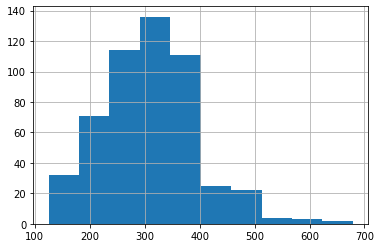

In [ ]:
df['Цена книги'].hist()

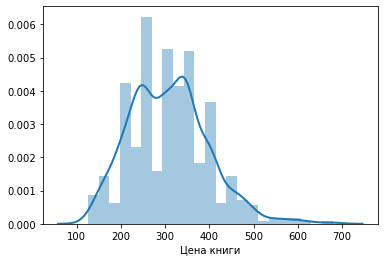

In [ ]:
sns.distplot(df['Цена книги'],kde=True)

In [ ]:
df['Цена книги'] = df['Цена книги'].astype('int64')
df['Кол-во страниц'] = df['Кол-во страниц'].astype('int64')
df['Кол-во оценок'] = df['Кол-во оценок'].astype('int64')
df['Оценка'] = df['Оценка'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ссылка                520 non-null    object 
 1   Название книги        520 non-null    object 
 2   Имя автора            520 non-null    object 
 3   Цена книги            520 non-null    int64  
 4   Оценка                520 non-null    float64
 5   Кол-во оценок         520 non-null    int64  
 6   Кол-во страниц        520 non-null    int64  
 7   Жанр                  520 non-null    object 
 8   Кол-во книг у автора  520 non-null    int64  
 9   Тип                   520 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 40.8+ KB


In [ ]:
df = df.drop('Ссылка', axis = 1)

In [ ]:
categorical_columns= [column for column in df.columns if df[column].dtype == 'object']
numerical_columns = [column for column in df.columns if df[column].dtype != 'object']

for column in categorical_columns:
    print('Признак: {}, кол-во уникальных значений: {}'.format(column, df[column].nunique()))
    print('Уникальные значения: ')
    print(df[column].value_counts(), '\n')

Признак: Название книги, кол-во уникальных значений: 415
Уникальные значения: 
Оправдание Острова                 4
Тайные виды на гору Фудзи          4
Тревожные люди                     4
Лавр                               4
Мир и война                        4
                                  ..
Отель «Нью-Гэмпшир»                1
Generation «П»                     1
Пандемия. Аркада. Эпизод первый    1
Фаворит (часть 4)                  1
Смотритель                         1
Name: Название книги, Length: 415, dtype: int64 

Признак: Имя автора, кол-во уникальных значений: 212
Уникальные значения: 
Виктор Пелевин          29
Дина Рубина             28
Борис Акунин            20
Евгений Водолазкин      20
Фредрик Бакман          19
                        ..
Т. Кристиан Миллер       1
Мишель Уэльбек           1
Фиона Валпи              1
Абрахам Вергезе          1
Александр Солженицын     1
Name: Имя автора, Length: 212, dtype: int64 

Признак: Жанр, кол-во уникальных значений: 42


In [ ]:
genre = list(df['Жанр'].unique())
genre1 = ['современная зарубежная литература', 'зарубежные детективы',
         'зарубежные приключения', 'зарубежная классика', 'зарубежная психология',
         'зарубежная эзотерическая литература', 'зарубежные любовные романы',
         'зарубежная образовательная литература', 'зарубежная публицистика']
genre2 = ['современная русская литература', 'советская литература', 'легкая проза',
          'публицистика', 'литература 20 века', 'пьесы и драматургия', 'классическая проза']
genre3 = ['историческая литература', 'биографии и мемуары', 'военное дело  спецслужбы',
         'книги о войне', 'истории из жизни', 'исторические приключения',
         'документальная литература','исторические детективы','контркультура']
genre4 = ['научная фантастика', 'мистика', 'боевики', 'книги для детей', 'боевая фантастика',
         'городское фэнтези', 'книги о приключениях', 'детские детективы',
         'домашние животные', 'книги о путешествиях', 'детская проза', 'книги для подростков']
genre5 = ['саморазвитие  личностный рост', 'практическая психология',
          'о психологии популярно', 'психотерапия', 'психоанализ']

In [ ]:
for i in range(len(df)):
    if df['Жанр'][i] in genre1:
        df['Жанр'][i] = 'зарубежная литература'
    elif df['Жанр'][i] in genre2:
        df['Жанр'][i] = 'русская литература'
    elif df['Жанр'][i] in genre3:
        df['Жанр'][i] = 'история'
    elif df['Жанр'][i] in genre4:
        df['Жанр'][i] = 'легкая литература'
    elif df['Жанр'][i] in genre5:
        df['Жанр'][i] = 'психология'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/o

In [ ]:
#for i in range(len(df)):
#    if df['Жанр'][i] not in ['современная зарубежная литература', 'современная русская литература', 'историческая литература']:
#        df['Жанр'][i] = 'другая литература'

In [ ]:
list(df['Жанр'].unique())

['зарубежная литература',
 'русская литература',
 'история',
 'легкая литература',
 'психология']

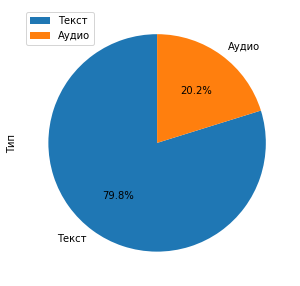

In [ ]:
df1 = pd.DataFrame(df['Тип'].value_counts())
df1.plot.pie(y = 'Тип', figsize=(5, 5), autopct='%1.1f%%', startangle = 90)

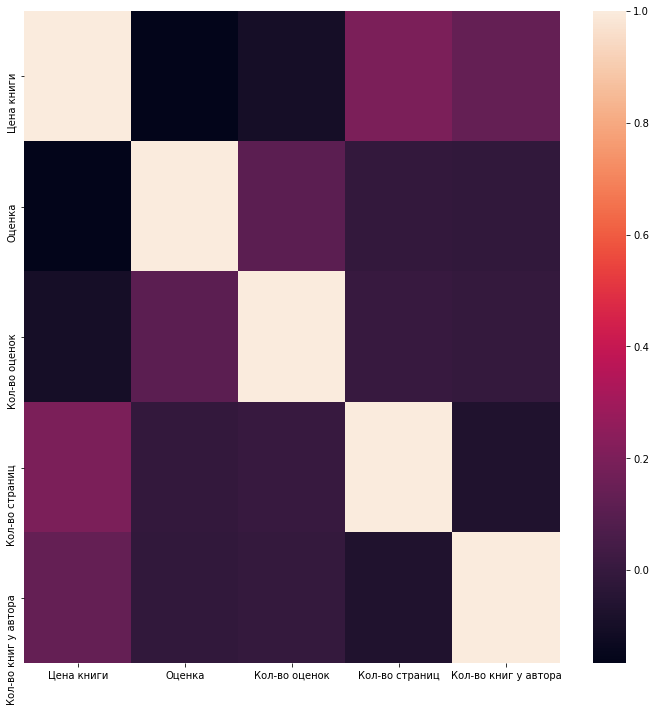

In [ ]:
correlation = df.corr()
plt.figure(figsize = (12 , 12))
sns.heatmap(correlation)

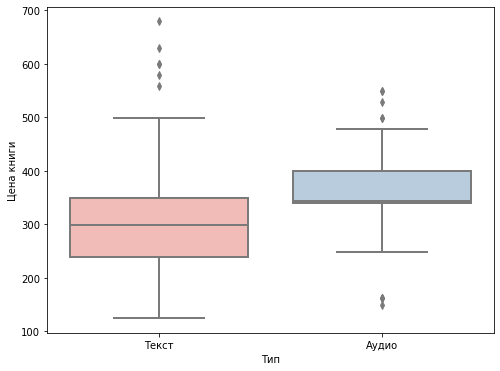

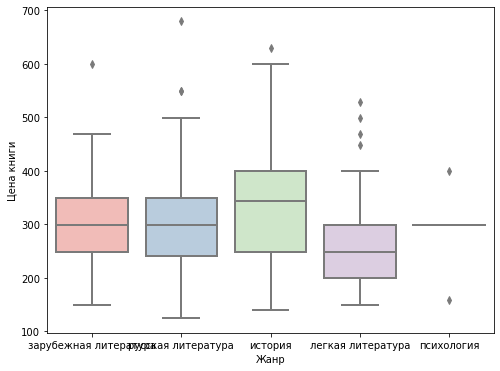

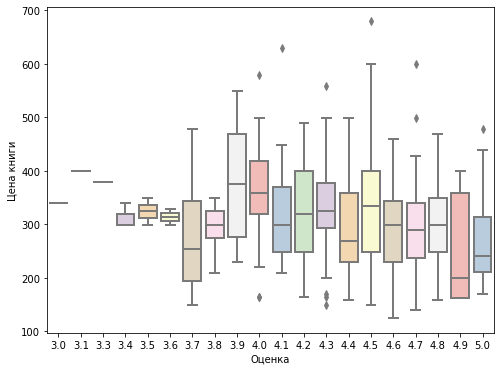

In [ ]:
for col in ['Тип', 'Жанр', 'Оценка']:
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    sns.boxplot(x = df[col], y = 'Цена книги', data = df, palette='Pastel1')

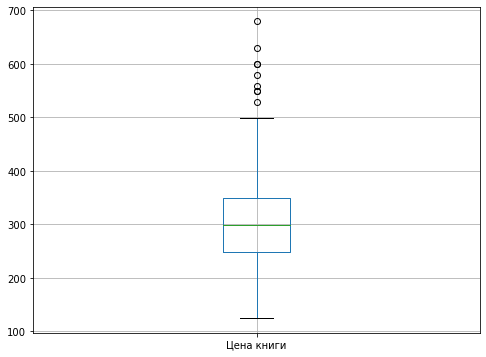

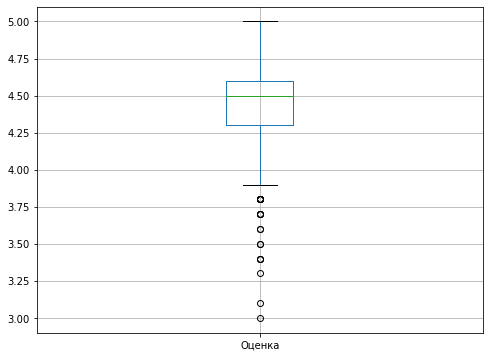

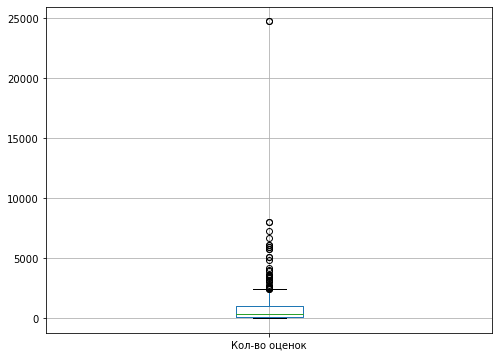

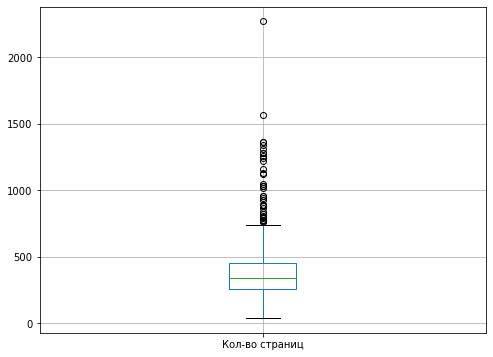

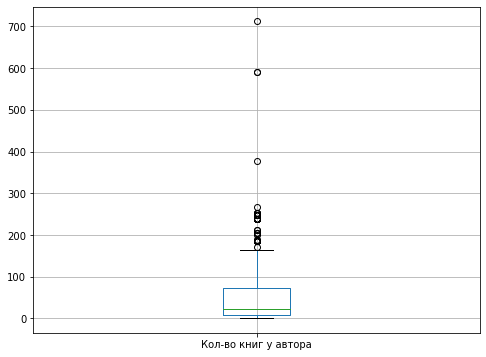

In [ ]:
for i in numerical_columns:
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    df.boxplot(column = i, ax = ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc10632dad0>,
      dtype=object)

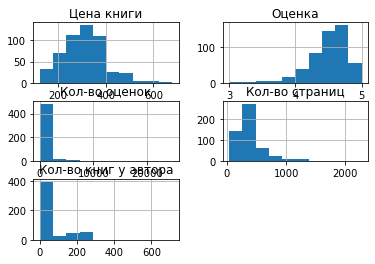

In [ ]:
df.hist()

{0: 'зарубежная литература', 1: 'история', 2: 'легкая литература', 3: 'психология', 4: 'русская литература'}


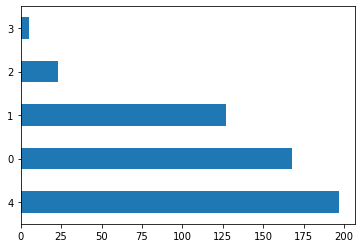

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
mapped_category = pd.Series(label_encoder.fit_transform(df['Жанр']))
mapped_category.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [ ]:
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
df1 = df

In [ ]:
df

,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,365,185,349,4.6,885,300,0,22,1
1,258,81,499,4.3,71,290,4,38,1
2,69,185,299,4.8,5082,330,0,22,1
3,205,28,419,4.4,1844,250,1,239,1
4,182,81,399,4.5,3188,390,1,38,1
...,...,...,...,...,...,...,...,...,...
515,57,39,299,4.5,19,1160,1,7,1
516,192,167,289,4.4,30,450,4,2,1
517,313,196,579,4.0,7,1120,1,97,1
518,302,2,164,4.3,199,380,1,104,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [ ]:
df

,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,0.881643,0.876777,0.404332,0.80,0.035778,0.116592,0.00,0.029536,1.0
1,0.623188,0.383886,0.675090,0.65,0.002833,0.112108,1.00,0.052039,1.0
2,0.166667,0.876777,0.314079,0.90,0.205642,0.130045,0.00,0.029536,1.0
3,0.495169,0.132701,0.530686,0.70,0.074591,0.094170,0.25,0.334740,1.0
4,0.439614,0.383886,0.494585,0.75,0.128987,0.156951,0.25,0.052039,1.0
...,...,...,...,...,...,...,...,...,...
515,0.137681,0.184834,0.314079,0.75,0.000729,0.502242,0.25,0.008439,1.0
516,0.463768,0.791469,0.296029,0.70,0.001174,0.183857,1.00,0.001406,1.0
517,0.756039,0.928910,0.819495,0.50,0.000243,0.484305,0.25,0.135021,1.0
518,0.729469,0.009479,0.070397,0.65,0.008014,0.152466,0.25,0.144866,1.0


In [ ]:
df = df.drop(['Название книги', 'Имя автора'], axis = 1)

In [ ]:
link = linkage(df, 'ward', 'euclidean')

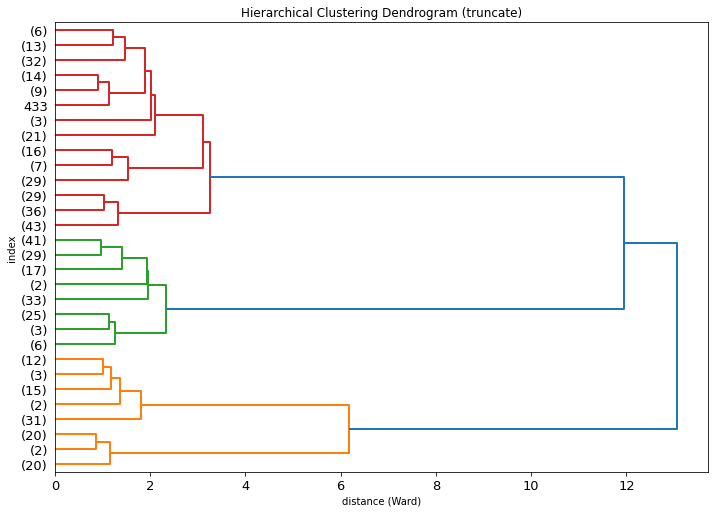

In [ ]:
matplotlib.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

dn = dendrogram(link,
                labels=df.index.tolist(),
                truncate_mode='lastp',
                orientation = "right",
                )
ax.tick_params(labelsize=13)
plt.title('Hierarchical Clustering Dendrogram (truncate)')
plt.ylabel('index')
plt.xlabel('distance (Ward)')
plt.show()

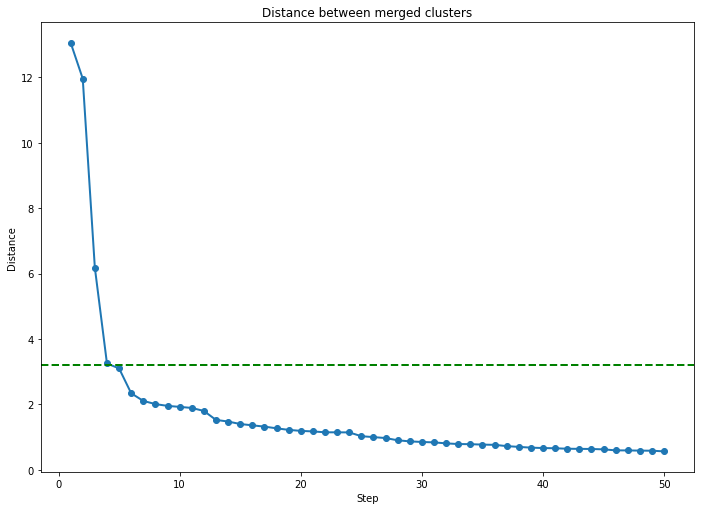

In [ ]:
dist = link[-50:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.axhline(3.2, c='g', linestyle='dashed')

plt.show()

In [ ]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')

In [ ]:
df.groupby('cluster').mean()

,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
cluster,,,,,,,
1,0.436007,0.729762,0.028074,0.089515,1.000000,0.154343,0.0
2,0.382958,0.781746,0.021180,0.118919,0.134921,0.106401,0.0
3,0.281542,0.708654,0.051110,0.151023,0.998397,0.118729,1.0
4,0.328959,0.719884,0.031110,0.184584,0.145753,0.059490,1.0


In [ ]:
df.groupby('cluster').size()

cluster
1     42
2     63
3    156
4    259
dtype: int64

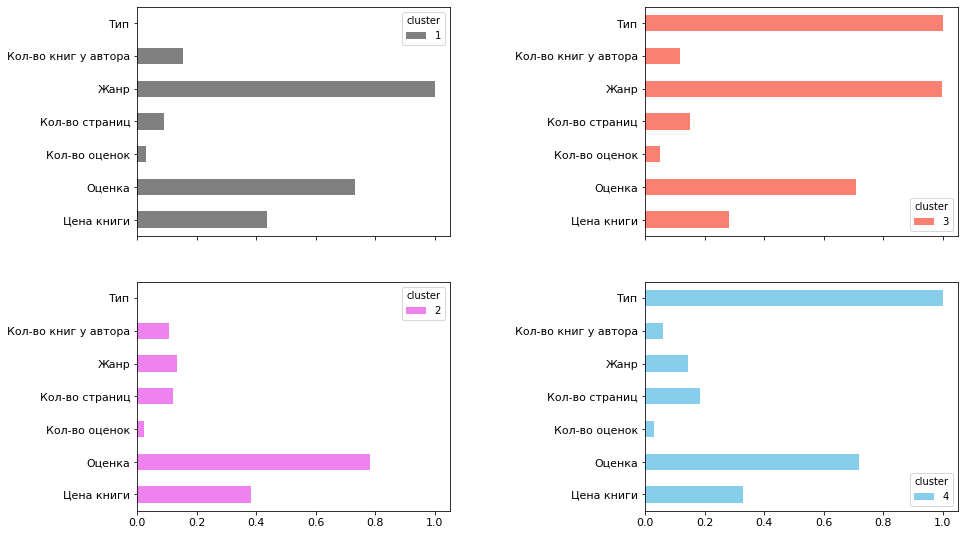

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(14.7, 9.27)
plt.subplots_adjust( wspace=0.625)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for i in range(2):
    for j in range(2):
        ax = axs[j, i]
        k += 1
        df[df.cluster == k].groupby('cluster').mean().T.plot.barh(ax = ax, color = c[k-1])
        ax.tick_params(labelsize = 11)



In [ ]:
df1

,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,365,185,349,4.6,885,300,0,22,1
1,258,81,499,4.3,71,290,4,38,1
2,69,185,299,4.8,5082,330,0,22,1
3,205,28,419,4.4,1844,250,1,239,1
4,182,81,399,4.5,3188,390,1,38,1
...,...,...,...,...,...,...,...,...,...
515,57,39,299,4.5,19,1160,1,7,1
516,192,167,289,4.4,30,450,4,2,1
517,313,196,579,4.0,7,1120,1,97,1
518,302,2,164,4.3,199,380,1,104,1


---

In [ ]:
df = df_
df['Название книги'] = [len(i) for i in df['Название книги']]
df = df.drop('Ссылка', axis = 1)

In [ ]:

df['Цена книги'] = df['Цена книги'].astype('int64')
df['Кол-во страниц'] = df['Кол-во страниц'].astype('int64')
df['Кол-во оценок'] = df['Кол-во оценок'].astype('int64')
df['Оценка'] = df['Оценка'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Название книги        520 non-null    int64  
 1   Имя автора            520 non-null    object 
 2   Цена книги            520 non-null    int64  
 3   Оценка                520 non-null    float64
 4   Кол-во оценок         520 non-null    int64  
 5   Кол-во страниц        520 non-null    int64  
 6   Жанр                  520 non-null    object 
 7   Кол-во книг у автора  520 non-null    int64  
 8   Тип                   520 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 36.7+ KB


In [ ]:
df

,Название книги,Имя автора,Цена книги,Оценка,Кол-во оценок,Кол-во страниц,Жанр,Кол-во книг у автора,Тип
0,14,Фредрик Бакман,349,4.6,885,300,современная зарубежная литература,22,Текст
1,18,Евгений Водолазкин,499,4.3,71,290,современная русская литература,38,Текст
2,16,Фредрик Бакман,299,4.8,5082,330,современная зарубежная литература,22,Текст
3,11,Борис Акунин,419,4.4,1844,250,историческая литература,239,Текст
4,4,Евгений Водолазкин,399,4.5,3188,390,историческая литература,38,Текст
...,...,...,...,...,...,...,...,...,...
515,15,Виктор Ремизов,299,4.5,19,1160,историческая литература,7,Текст
516,12,Светлана Сачкова,289,4.4,30,450,современная русская литература,2,Текст
517,12,Эдвард Радзинский,579,4.0,7,1120,биографии и мемуары,97,Текст
518,24,Александр Михайловский,164,4.3,199,380,исторические приключения,104,Текст


In [ ]:
X = df.drop('Цена книги', axis=1)
y = df['Цена книги'].values

In [ ]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols=['Имя автора', 'Жанр', 'Тип'])
encoder.fit(X, y)
X_num = encoder.transform(X)

/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.5,
                                                          random_state=17)
print(X_train.shape, X_test.shape)

(260, 8) (260, 8)


from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
from sklearn.linear_model import *

In [ ]:
import statsmodels.api as sm
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              635.3
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   2.80e-162
Time:                        05:28:00   Log-Likelihood:                         -1473.4
No. Observations:                 260   AIC:                                      2963.
Df Residuals:                     252   BIC:                                      2991.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Название книги           0.2351      0.262      0.897      0.371      -0.281       0.751
Имя автора               0.9292      0.104      8.969      0.000       0.725       1.133
Оценка                 -51.1842     13.083     -3.912      0.000     -76.951     -25.417
Кол-во оценок           -0.0045      0.002     -1.984      0.048      -0.009    -3.4e-05
Кол-во страниц           0.0450      0.017      2.575      0.011       0.011       0.079
Жанр                     0.3298      0.168      1.965      0.051      -0.001       0.660
Кол-во книг у автора     0.0517      0.046      1.118      0.265      -0.039       0.143
Тип                      0.3957      0.193      2.050      0.041       0.015       0.776
==============================================================================
Omnibus:                       50.726   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.133
Skew:                           0.904   Prob(JB):                     1.11e-27
Kurtosis:                       5.862   Cond. No.                     6.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
y_pred = model.predict(X_num)

(0.0, 700.0)

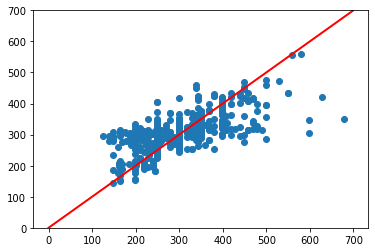

In [ ]:
plt.scatter(df['Цена книги'], y_pred)
plt.plot(list(range(700)), 'r')
plt.ylim([0, 700])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [ ]:
from sklearn.svm import SVC
model = SVC().fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))
predictions = model.predict(X_test)

0.1076923076923077
0.13076923076923078


In [ ]:
lin_reg = LinearRegression().fit(X_train, y_train)
tree = RandomForestRegressor().fit(X_train, y_train)
knn = KNeighborsRegressor().fit(X_train, y_train)
ridge = Ridge().fit(X_train, y_train)
svc = SVC().fit(X_train, y_train)
lasso = Lasso().fit(X_train, y_train)
lascv = LassoCV().fit(X_train, y_train)
ridcv = RidgeCV().fit(X_train, y_train)

x = []
for model in [lin_reg, tree, knn, ridge, svc, lasso, lascv, ridcv]:
    x.append({
        'model': model.__class__.__name__,
        'r2_test': r2_score(y_test, model.predict(X_test))
    })
pd.DataFrame(x)

NameError: name 'LinearRegression' is not defined

In [ ]:
def find_best_model(model_class, X_train, X_test, y_train, y_test, params_grid, cv, name=None):
    model_grid = GridSearchCV(model_class, params_grid, cv=cv, n_jobs=-1, verbose=True)
    model_grid.fit(X_train, y_train)
    best_params = model_grid.best_params_
    r2 = r2_score(y_test, model_grid.predict(X_test))
    return (model_grid.best_estimator_,
            pd.DataFrame([{"model": name or model_grid.best_estimator_.__class__.__name__, 'r2_train': model_grid.best_score_,
                          'r2_test':r2, **best_params}]))



In [ ]:
def test_all_models(X_train, X_test, y_train, y_test):
    tree_params = {'max_depth': range(1,11),
               'max_features': range(1,X_train.shape[1])}
    best_tree, stats_tree = find_best_model(RandomForestRegressor(),
                                                        X_train, X_test, y_train, y_test,
                                                        tree_params, cv=5)
    knn_params = {'knn__n_neighbors': range(1, 10)}
    knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])

    best_knn, stats_knn = find_best_model(knn_pipe, X_train, X_test, y_train, y_test,
                                                      knn_params, cv=5, name='KNN')

    ridge_params = {'alpha': [i/10 for i in range(1, 10)],
               'normalize': [True, False]}
    best_rigde, stats_rigde = find_best_model(Ridge(random_state=42),
                                                        X_train, X_test, y_train, y_test,
                                                        ridge_params, cv=5)
    #svc_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]}
    #svc_params = {'kernel': ['linear'], 'C': [1, 5], 'gamma': [0.001, 0.005]}
    #best_svc, stats_svc = find_best_model(svm.SVC(), X_train, X_test, y_train, y_test, svc_params, cv = 5)

    comp = pd.concat([stats_tree, stats_knn, stats_rigde], axis=0, ignore_index=True)
    return comp[['model', 'r2_train', 'r2_test']]


In [ ]:
test_all_models(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   32.6s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished


,model,r2_train,r2_test
0,RandomForestRegressor,0.408719,0.545021
1,KNN,0.297443,0.406048
2,Ridge,0.337925,0.530637


(0.0, 700.0)

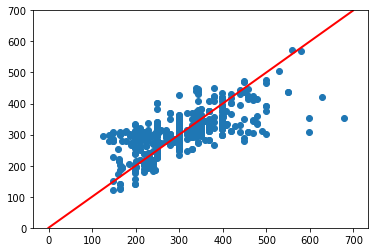

In [ ]:
plt.scatter(df['Цена книги'], lin_reg.predict(X_num))
plt.plot(list(range(700)), 'r')
plt.ylim([0, 700])

In [ ]:
def call(model):
    try:
        params = {}
        for param in df.columns:
            if param == 'Цена книги':
                continue
            params[param] = input(f'Введите значение {param}: ')
        new_data = pd.DataFrame([params])
        new_data = new_data.astype({
            'Название книги': int,
            'Имя автора': 'category',
            'Оценка': float,
            'Кол-во оценок': int,
            'Кол-во страниц': int,
            'Жанр': 'category',
            'Кол-во книг у автора': int,
            'Тип': 'category',
        })
        new_data = encoder.transform(new_data)
        return {'y': model.predict(new_data)[0]}
    except:
        print("Что-то пошло не так!")
        return {}

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib')
dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [ ]:
model = load('model.joblib')
encoder = load('encoder.joblib')

In [ ]:
call(model)

Введите значение Название книги: 30
Введите значение Имя автора: Фредрик Бакман
Введите значение Оценка: 4.8
Введите значение Кол-во оценок: 600
Введите значение Кол-во страниц: 380
Введите значение Жанр: современная зарубежная литература
Введите значение Кол-во книг у автора: 22
Введите значение Тип: Текст


{'y': 299}